In [1]:
# loading libraries
import numpy  as np                
import pandas as pd
import matplotlib.pyplot as plt   
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import os
import re
import math as m

In [2]:
def working_capacity_per_time(t1, t2, plot=False):
    #fig, axs = plt.subplots(1, 2,  figsize=(6, 3))
    fig, axs = plt.subplot_mosaic([['left', 'right', 'right']],figsize=(9, 3), constrained_layout=True)
    axs['left'].plot( np.linspace(0, 30, num=300), isotherm_interpolate_RH_to_uptake_ads(np.linspace(0, 30, num=300)), c='green')
    axs['left'].set_ylabel('Uptake, wt.%', c='green')
    axs['left'].set_xlabel('RH, %')
    
    t0 = 0
    
    w0 = 0
    
    work_capacity_all = []
    
    def curve( w0,  t1, Kads, Kdes, t_range, RH):
        uptake_out = []
        B = w0
        t0 = t_range[0]
        for i, t in enumerate(t_range):
            B = B + (t-t0)*(np.multiply( Kads* (RH - isotherm_interpolate_uptake_to_RH_ads(B)) , RH>isotherm_interpolate_uptake_to_RH_ads(B)) \
            + np.multiply( Kdes * (RH - isotherm_interpolate_uptake_to_RH_des(B)), RH<isotherm_interpolate_uptake_to_RH_des(B))   
                      )  
            uptake_out.append(B)
            t0=t
        return uptake_out
    ax2 = axs['right'].twinx()
    w_last = w0
    workcapacity_ads_last = 0
    uptake_des_last = 0
    equilibrium_cycle = 0
    for i in range(1):
        t_range = np.linspace(0+i*(t1+t2), t1+i*(t1+t2), num=3000)
        w_range = curve( w_last,  t1, Kads, Kdes, t_range, 30)
        w_last = w_range[-1]
        work_capacity = w_last
        #plt.scatter(t_range[-1],w_last)
        
        ax2.plot(t_range, [30 for i in t_range] , c='b', linestyle='dotted',)
        axs['right'].plot(t_range, w_range, c='r')
        
        t_range = np.linspace(t1+i*(t1+t2), (t1+t2)+i*(t1+t2), num=3000)
        w_range = curve(w_last,  t2, Kads, Kdes, t_range, 0)
        w_last = w_range[-1]
        work_capacity = work_capacity - w_last
        #plt.scatter(t_range[-1],w_last)
        
        ax2.plot(t_range, [0 for i in t_range], c='b', linestyle='dotted')
        axs['right'].plot(t_range, w_range, c='r')
        
        work_capacity_all.append(work_capacity)
        if (abs(uptake_des_last - w_range[-1]) <tolerance)&(abs(workcapacity_ads_last-work_capacity) < tolerance):
            equilibrium_cycle = i
            #print(i)
            break
        #print(work_capacity, work_capacity/(t1+t2))
        uptake_des_last = w_range[-1]
        workcapacity_ads_last = work_capacity
        ## plot (unnest x and y)
    
    
    axs['left'].set_title('Isotherm')
    axs['right'].set_title('Kinetics')
    axs['right'].set_ylabel('Uptake, wt.%', c='r')
    ax2.set_ylabel('RH, %', c='b')
    axs['right'].set_xlabel('Time, min')
    plt.tight_layout()
    plt.show()
    return work_capacity_all[-1]/(t1+t2), equilibrium_cycle, equilibrium_cycle*(t1+t2)



In [3]:
##################################################
####### import and interpolate isotherm 
##################################################
def import_and_interpolate_isotherm(filename, path):
    global isotherm_interpolate_uptake_to_RH_ads
    global isotherm_interpolate_uptake_to_RH_des
    global isotherm_interpolate_RH_to_uptake_ads
    global isotherm_interpolate_RH_to_uptake_des
    ### Adsorption
    
    df = pd.read_csv(path + filename)

    from scipy import interpolate
    f_ads = interpolate.interp1d(df.uptake_ads.to_list(),  df.RH_ads.to_list(),fill_value="extrapolate")
    
    def isotherm_interpolate_uptake_to_RH_ads(t):
        return f_ads(t)
    
    f_des = interpolate.interp1d(df.uptake_des.to_list(),  df.RH_des.to_list(),fill_value="extrapolate")
    
    def isotherm_interpolate_uptake_to_RH_des(t):
        return f_des(t)
    
    f_ads2 = interpolate.interp1d(  df.RH_ads.to_list(),df.uptake_ads.to_list(),fill_value="extrapolate")
    
    def isotherm_interpolate_RH_to_uptake_ads(t):
        return f_ads2(t)
    
    f_des2 = interpolate.interp1d(  df.RH_des.to_list(),df.uptake_des.to_list(),fill_value="extrapolate")
    
    def isotherm_interpolate_RH_to_uptake_des(t):
        return f_des2(t)
    fig = plt.figure( figsize=(4, 3))
    
    plt.plot( df.RH_ads, df.uptake_ads,c='b')
    plt.scatter( df.RH_ads, df.uptake_ads, label='Adsorption',c='b')
    
    plt.plot( df.RH_des, df.uptake_des,c='r')
    plt.scatter( df.RH_des, df.uptake_des, label='Desorption',c='r')
    
    plt.ylabel('Uptake, wt.%')
    plt.xlabel('RH, %')
    plt.legend()
    plt.show()

### Different inflection point

['0-30_line.csv', '1%RH_2step.csv', '10%RH.csv', '10%RH_2step.csv', '10-20_line.csv', '13%RH_2step.csv', '15%RH.csv', '20%RH+10%hist.csv', '20%RH.csv', '25%RH.csv', '5%RH.csv', '5%RH_2step.csv']


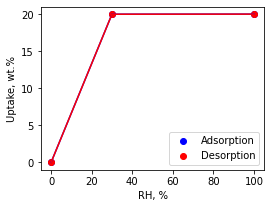

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


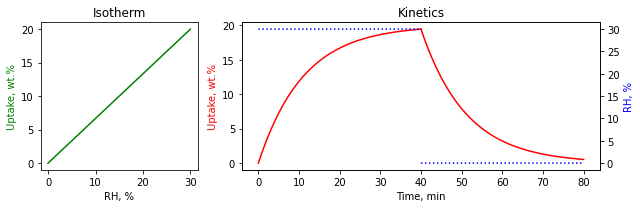

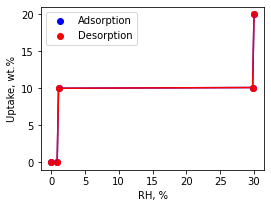

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


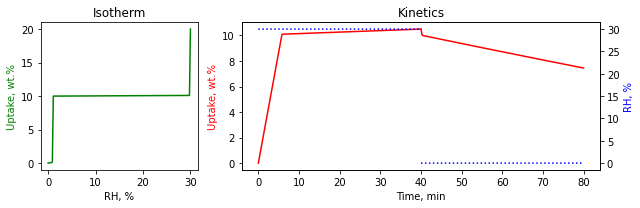

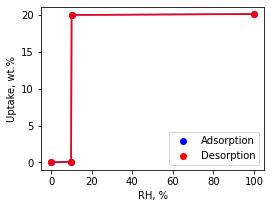

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


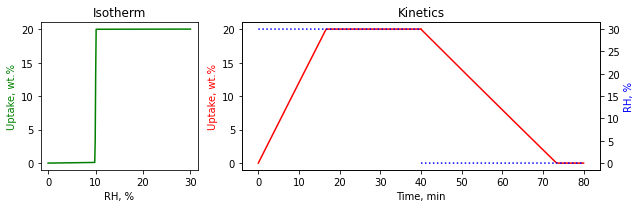

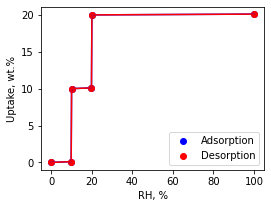

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


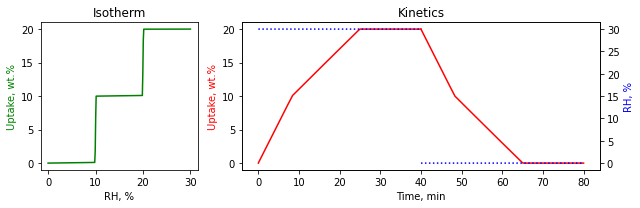

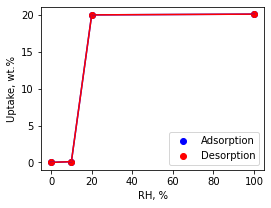

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


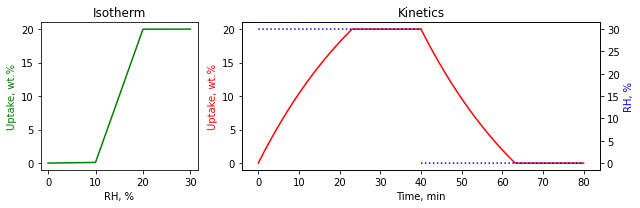

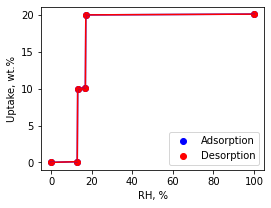

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


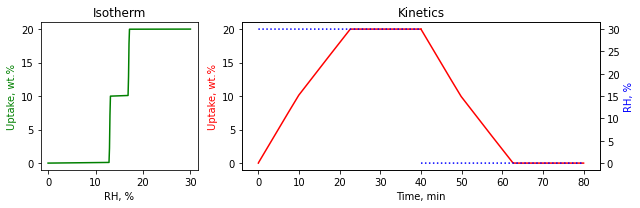

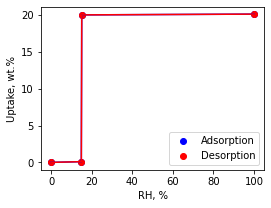

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


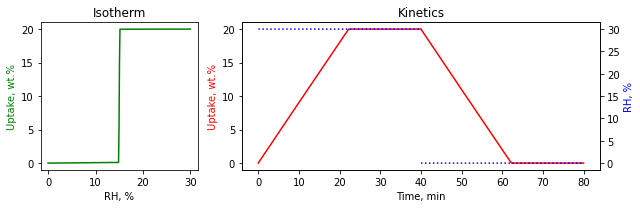

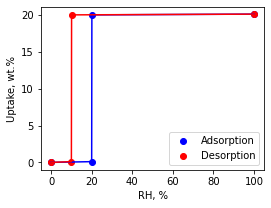

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


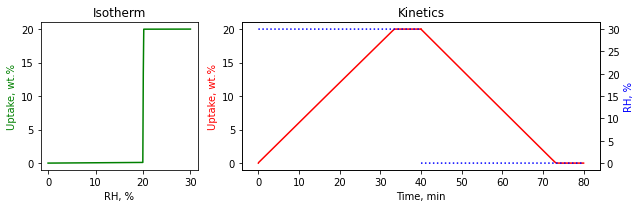

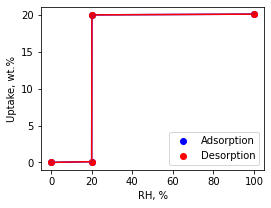

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


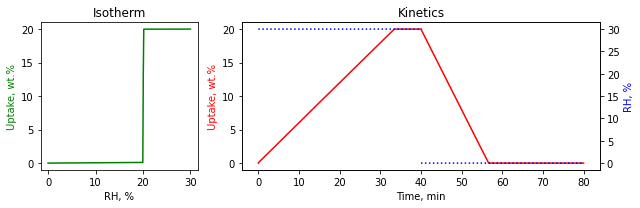

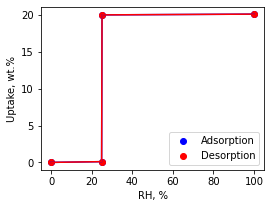

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


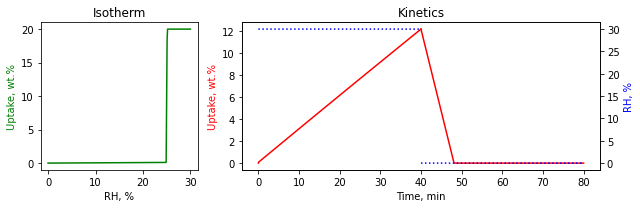

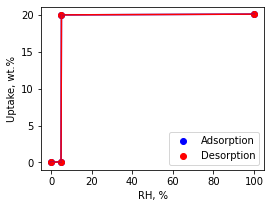

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


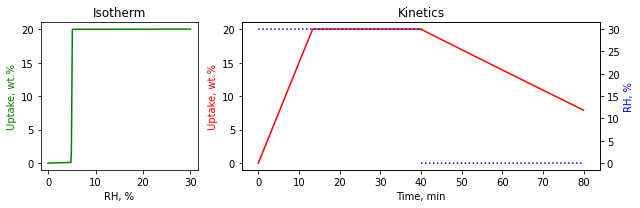

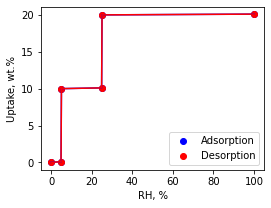

C:\Users\Andrey.Bezrukov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


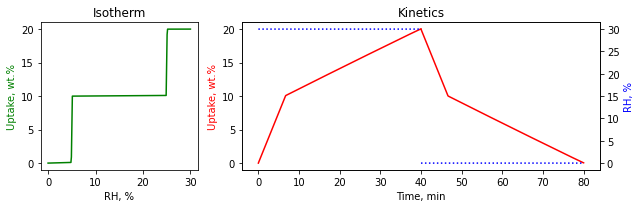

In [4]:
path = '../../data/hypothetical_isotherms/diff_inflection_point/'
filelist = [i for i in os.listdir(path) if i[-4:]=='.csv']


print(filelist)
for filename in filelist:
    import_and_interpolate_isotherm(filename, path)

    number_of_steps = 100
    tolerance = 0.01
    t_ads_range = np.linspace(1, 100, num=number_of_steps)
    t_des_range = np.linspace(1, 100, num=number_of_steps)

    zero_mass = 5
    Kads = 0.3/zero_mass
    Kdes = 0.3/zero_mass


    working_capacity_per_time(40,40, plot = True)